Shape: (480000, 4)
Sample rate: 48000 Hz
For type of wave TILE, saliency was 0.6929706582511489
Tile (90, -180) to (70, -160): saliency = 0.6930
For type of wave TILE, saliency was 0.6923879076393729
Tile (90, -160) to (70, -140): saliency = 0.6924
For type of wave TILE, saliency was 0.7027367574413801
Tile (90, -140) to (70, -120): saliency = 0.7027
For type of wave TILE, saliency was 0.7106273792119882
Tile (90, -120) to (70, -100): saliency = 0.7106
For type of wave TILE, saliency was 0.7050403463075359
Tile (90, -100) to (70, -80): saliency = 0.7050
For type of wave TILE, saliency was 0.7014925764513837
Tile (90, -80) to (70, -60): saliency = 0.7015
For type of wave TILE, saliency was 0.7087075500580606
Tile (90, -60) to (70, -40): saliency = 0.7087
For type of wave TILE, saliency was 0.7000506704746745
Tile (90, -40) to (70, -20): saliency = 0.7001
For type of wave TILE, saliency was 0.6965349702861167
Tile (90, -20) to (70, 0): saliency = 0.6965
For type of wave TILE, saliency wa

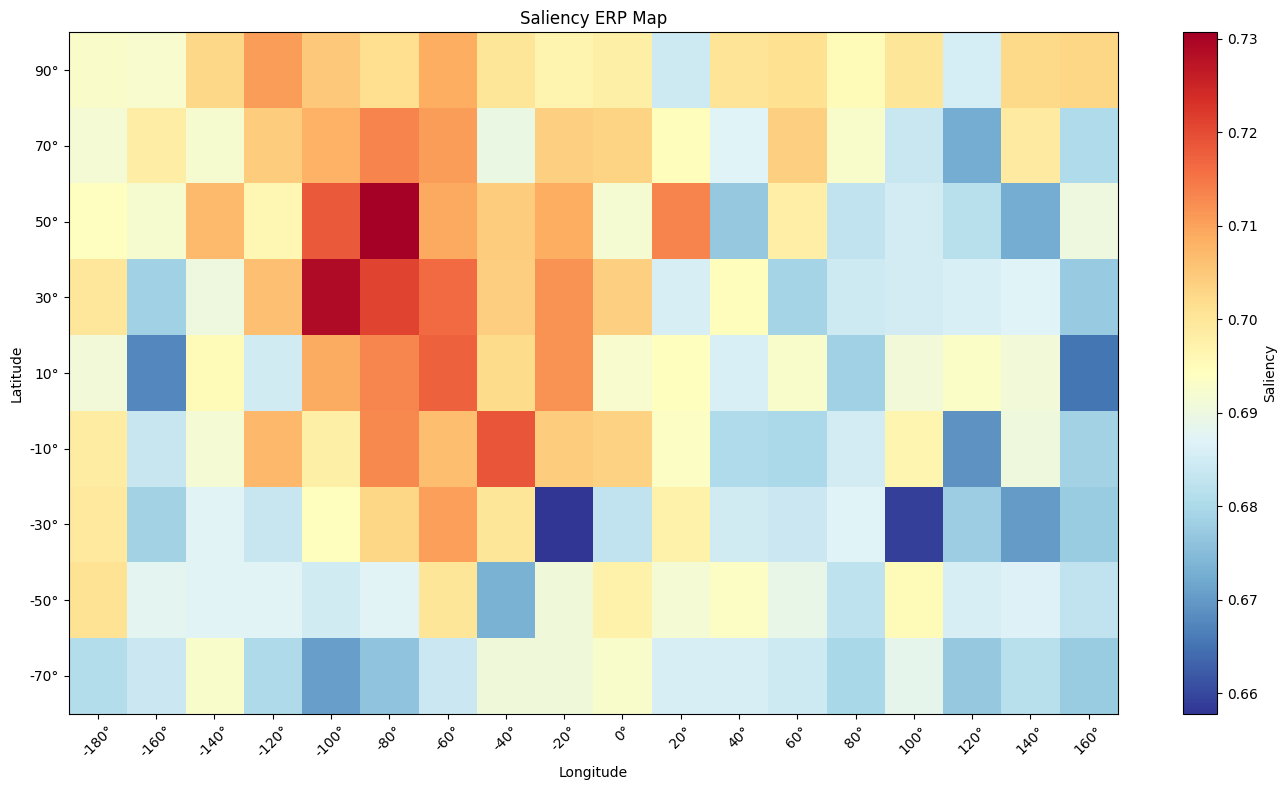

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import soundfile as sf
import librosa
from scipy.integrate import dblquad

# Load the .wav file
data, samplerate = sf.read("SaliencySoundTest/ambisonic_audio_4ch_10.wav")

def compute_audio_at_direction(W: np.ndarray, X: np.ndarray, 
                                   Y: np.ndarray, Z: np.ndarray,
                                   top_left: tuple, bottom_right: tuple) -> np.ndarray:
    """
    Compute average audio waveform over a rectangular tile defined by lat/lon bounds.
    Uses spherical harmonic expansion with proper integration over the region.
    
    The sound field is: p(θ,ϕ,t) ≈ W(t)Y_W(θ,ϕ) + X(t)Y_X(θ,ϕ) + Y(t)Y_Y(θ,ϕ) + Z(t)Y_Z(θ,ϕ)
    
    The average over region R is: <p(t)>_R = (1/A) ∫_R p(θ,ϕ,t) dΩ
    where A = ∫_R dΩ is the solid angle of the region
    
    This becomes: <p(t)>_R = W(t) * (1/A ∫_R Y_W dΩ) + X(t) * (1/A ∫_R Y_X dΩ) + ...
    """
    top_left_lat, top_left_lon = top_left
    bottom_right_lat, bottom_right_lon = bottom_right
    
    # Convert bounds to radians
    lat_min_rad = np.radians(bottom_right_lat)
    lat_max_rad = np.radians(top_left_lat)
    lon_min_rad = np.radians(top_left_lon)
    lon_max_rad = np.radians(bottom_right_lon)
    
    # Compute solid angle (area) of the region: A = ∫∫ cos(lat) dlat dlon
    def integrand_area(lon, lat):
        return np.cos(lat)
    
    area, _ = dblquad(integrand_area, lat_min_rad, lat_max_rad, lon_min_rad, lon_max_rad)
    
    # Integrate Y_W over the region: ∫∫ 1 * cos(lat) dlat dlon
    def integrand_Y_W(lon, lat):
        return 1.0 * np.cos(lat)
    
    integral_Y_W, _ = dblquad(integrand_Y_W, lat_min_rad, lat_max_rad, lon_min_rad, lon_max_rad)
    
    # Integrate Y_X over the region: ∫∫ cos(lat)cos(lon) * cos(lat) dlat dlon
    def integrand_Y_X(lon, lat):
        return np.cos(lat) * np.cos(lon) * np.cos(lat)
    
    integral_Y_X, _ = dblquad(integrand_Y_X, lat_min_rad, lat_max_rad, lon_min_rad, lon_max_rad)
    
    # Integrate Y_Y over the region: ∫∫ cos(lat)sin(lon) * cos(lat) dlat dlon
    def integrand_Y_Y(lon, lat):
        return np.cos(lat) * np.sin(lon) * np.cos(lat)
    
    integral_Y_Y, _ = dblquad(integrand_Y_Y, lat_min_rad, lat_max_rad, lon_min_rad, lon_max_rad)
    
    # Integrate Y_Z over the region: ∫∫ sin(lat) * cos(lat) dlat dlon
    def integrand_Y_Z(lon, lat):
        return np.sin(lat) * np.cos(lat)
    
    integral_Y_Z, _ = dblquad(integrand_Y_Z, lat_min_rad, lat_max_rad, lon_min_rad, lon_max_rad)
    
    # Normalize by area to get average
    avg_Y_W = integral_Y_W / area
    avg_Y_X = integral_Y_X / area
    avg_Y_Y = integral_Y_Y / area
    avg_Y_Z = integral_Y_Z / area
    
    # Reconstruct average waveform over the tile
    wave = avg_Y_W * W + avg_Y_X * X + avg_Y_Y * Y + avg_Y_Z * Z
    
    return wave
    
print(f"Shape: {data.shape}")   # (num_samples, 4)
print(f"Sample rate: {samplerate} Hz")

# Split into channels
W = data[:, 0]
X = data[:, 1]
Y = data[:, 2]
Z = data[:, 3]

def processWave(type, wave, sampleRate):
    windowSize = 2048
    hopSize = 100
    
    # converts this to a Short-Time Fourier Transform. Tells you how much eergy has at each frequency over time.
    # does this by going through windows. Length of each window defined by n_fft. Then, shifts window to right by length
    # hop length. at each window, computes how much of each frequency is present.
    # final value is 2D array of rows being each frequency, columns being time (which is now the windows), so value being amplitude/energy for that time and frequency
    stftWave = np.abs(librosa.stft(wave, n_fft=windowSize, hop_length=hopSize))
    # when we get the mel, that just converts all the frequencies to 128 possible onces, which are moreso frequencies humans can hear. So compressing
    # the frequencies from a large number of frequencies to a smaller number, in this case n_mels amount
    mel = librosa.feature.melspectrogram(S = stftWave, sr= sampleRate, n_mels = 128)
    # converts from power scaling of audio to decibel scaling, cause humans perceive in moreso logarithm of audio (so higher sounds kinda taper off to us)
    logMel = librosa.power_to_db(mel, ref=np.max)

    # gets overall frame energy, including amplitude
    frameEnergy = np.sqrt(np.mean(logMel ** 2, axis=0))
    # gets the contrast in energy between frequencies within a specific frequency band, so where some frequencies bands may have parts of high energy frequencies, while other parts are low energy
    contrast = librosa.feature.spectral_contrast(S = stftWave, sr=sampleRate)
    # combines the difference frequency bands to get a average contrast for that time frame
    contrast = np.mean(contrast, axis=0)
    # basically gets how much the sound chagnes over time. Does this by getting differnece over time fimes with np.diff, squaring that value, and getting its sum
    temporal_novelty = np.sum(np.diff(logMel, axis=1) ** 2, axis=0)
    # do this to add an extra value cause rn, the length is T - 1, since you're getting difference between frames. So add 1 to get it to T length
    temporal_novelty = np.insert(temporal_novelty, 0, 0)

    # standard normalization
    frameEnergyNorm = frameEnergy / np.max(frameEnergy)
    contrastNorm = contrast / np.max(contrast)
    temporal_novelty_norm = temporal_novelty / np.max(temporal_novelty)

    # gets it for the overall time
    finalSaliency = 0.5 * frameEnergyNorm + 0.3 * contrastNorm + 0.2 * temporal_novelty_norm

    print(f"For type of wave {type}, saliency was {np.mean(finalSaliency)}")
    return np.mean(finalSaliency)

    secondsIn = 6.5
    # divide by hoSize as first secondIn * sr gets the specific sample we want. Dividing by hopSize tells us how many windows to traverse
    # to get to that sample, as say if it's less than hopSize, its in the window at index 0, if it's slightly more, it's in the window at index 1, etc
    index = int(secondsIn * sampleRate / hopSize)



# Create a grid of saliency values
latitudes = list(range(90, -90, -20))
longitudes = list(range(-180, 180, 20))

saliency_grid = np.zeros((len(latitudes), len(longitudes)))

# Compute saliency for each tile
for lat_idx, latitude in enumerate(latitudes):
    for lon_idx, longitude in enumerate(longitudes):
        topLeft = (latitude, longitude)
        bottomRight = (latitude - 20, longitude + 20)
        wave = compute_audio_at_direction(W, X, Y, Z, topLeft, bottomRight)
        saliency = processWave("TILE", wave, samplerate)
        saliency_grid[lat_idx, lon_idx] = saliency
        print(f"Tile {topLeft} to {bottomRight}: saliency = {saliency:.4f}")

# Create ERP-style heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Plot heatmap
im = ax.imshow(saliency_grid, cmap='RdYlBu_r', aspect='auto', origin='upper')

# Set ticks and labels
ax.set_xticks(range(len(longitudes)))
ax.set_yticks(range(len(latitudes)))
ax.set_xticklabels([f'{lon}°' for lon in longitudes], rotation=45)
ax.set_yticklabels([f'{lat}°' for lat in latitudes])

# Labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Saliency ERP Map')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Saliency')

plt.tight_layout()
plt.show()